# Analysis for Alameda

In [15]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel

def remap_severity(severity_series):
    """
    Remap collision severity values to a reversed scale and convert to an ordered categorical variable.
    
    The function converts severity scores from the original scale to a reversed scale as follows:
        1 → 4
        2 → 3
        3 → 2
        4 → 1
        
    Parameters:
    severity_series (pd.Series): Series containing collision severity values as strings or numbers.
    
    Returns:
    pd.Categorical: An ordered categorical series with severity levels [1, 2, 3, 4],
                    where 1 represents the least severe and 4 the most severe.
    """
    # Convert severity values to numeric, coercing errors to NaN
    severity_numeric = pd.to_numeric(severity_series, errors="coerce")
    # Define the mapping from original to reversed scale
    severity_mapping = {1: 4, 2: 3, 3: 2, 4: 1}
    remapped = severity_numeric.map(severity_mapping)
    # Define the order for the categorical variable
    severity_order = [1, 2, 3, 4]
    return pd.Categorical(remapped, categories=severity_order, ordered=True)

def categorize_time_of_day(time_str):
    """
    Categorize a time (given as a string) into a time-of-day group.
    
    The function interprets the input as a time in HHMM format and assigns:
        "M" for Morning (06:00 - 11:59),
        "A" for Afternoon (12:00 - 17:59),
        "E" for Evening (18:00 - 23:59),
        "N" for Night (00:00 - 05:59).
    
    Parameters:
    time_str (str): A string representing the time in HHMM format (e.g., "0600" for 6:00 AM).
    
    Returns:
    str: A single character representing the time of day ("M", "A", "E", or "N").
         If the input is invalid, returns np.nan.
    """
    try:
        time_int = int(time_str)
        if 600 <= time_int < 1200:
            return "M"  # Morning
        elif 1200 <= time_int < 1800:
            return "A"  # Afternoon
        elif 1800 <= time_int < 2400:
            return "E"  # Evening
        elif 0 <= time_int < 600:
            return "N"  # Night
    except (ValueError, TypeError):
        return np.nan

# Load dataset
df = pd.read_csv("Crashes_Alameda_2223.csv", dtype=str)

# Keep only relevant columns
columns_to_keep = ["COLLISION_SEVERITY", "DAY_OF_WEEK", "COLLISION_TIME"]
df = df[columns_to_keep]

# Apply severity remapping using the dedicated function
df["COLLISION_SEVERITY"] = remap_severity(df["COLLISION_SEVERITY"])

# Create TIME_OF_DAY by categorizing COLLISION_TIME and convert to a categorical variable
df["TIME_OF_DAY"] = df["COLLISION_TIME"].apply(categorize_time_of_day).astype("category")
df.drop(columns=["COLLISION_TIME"], inplace=True)

# Collapse DAY_OF_WEEK into "Weekday" (Mon-Fri) vs. "Weekend" (Sat-Sun)
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].apply(lambda x: "Weekday" if x in ["1", "2", "3", "4", "5"] else "Weekend")




In [16]:
# Apply dummy encoding, keeping "Weekday" as the reference category
df = pd.get_dummies(df, columns=["DAY_OF_WEEK", "TIME_OF_DAY"], drop_first=True)

# Define independent variables (all columns except the target)
independent_vars = df.columns.difference(["COLLISION_SEVERITY"])

# Specify and calibrate the Ordered Logit Model
model = OrderedModel(
    df["COLLISION_SEVERITY"],
    df[independent_vars],
    distr="logit"
)

result = model.fit(method="bfgs")
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.932356
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:     COLLISION_SEVERITY   Log-Likelihood:                -13058.
Model:                   OrderedModel   AIC:                         2.613e+04
Method:            Maximum Likelihood   BIC:                         2.618e+04
Date:                Sun, 09 Mar 2025                                         
Time:                        20:22:35                                         
No. Observations:               14005                                         
Df Residuals:                   13998                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [17]:
# Compute and display Odds Ratios
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:\n", odds_ratios)

# Predict probabilities for each severity level
predicted_probs = result.predict()

# Convert predictions to a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs)

# Determine the most likely severity level for each observation
df["Predicted_Severity"] = predicted_probs_df.idxmax(axis=1)

# Display performance metrics with a confusion matrix (objective results only)
confusion_matrix = pd.crosstab(df["COLLISION_SEVERITY"], df["Predicted_Severity"],
                               rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", confusion_matrix)



Odds Ratios:
 DAY_OF_WEEK_Weekend    1.122559
TIME_OF_DAY_E          1.337320
TIME_OF_DAY_M          0.905084
TIME_OF_DAY_N          1.821933
1/2                    1.491617
2/3                    2.127494
3/4                    1.867154
dtype: float64

Confusion Matrix:
 Predicted     0    1
Actual              
1          7609  299
2          4651  245
3           907   92
4           176   26


[[7609  299    0    0]
 [4651  245    0    0]
 [ 907   92    0    0]
 [ 176   26    0    0]]


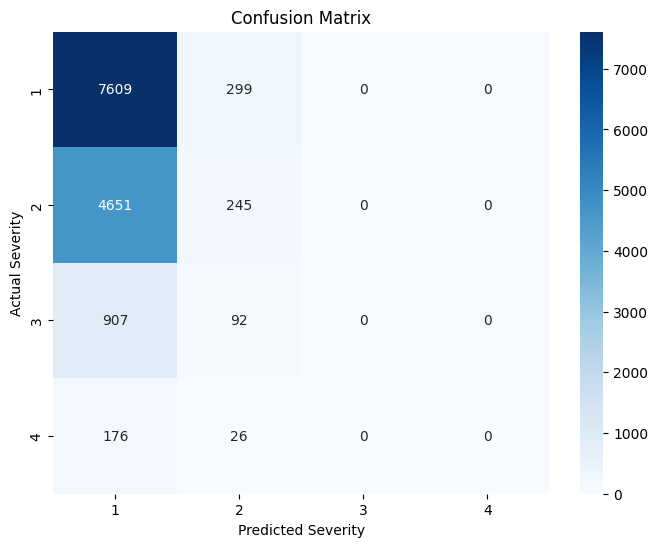

In [18]:
# Get the predicted class (severity level)
predicted = result.predict().argmax(axis=1) + 1  # +1 because argmax is zero-indexed
actual = df["COLLISION_SEVERITY"]

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

# Visualize it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1, 2, 3, 4],
            yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix')
plt.show()

# Analysis for San Francisco

In [19]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel

def remap_severity(severity_series):
    """
    Remap collision severity values to a reversed scale and convert to an ordered categorical variable.
    
    The function converts severity scores from the original scale to a reversed scale as follows:
        1 → 4
        2 → 3
        3 → 2
        4 → 1
        
    Parameters:
    severity_series (pd.Series): Series containing collision severity values as strings or numbers.
    
    Returns:
    pd.Categorical: An ordered categorical series with severity levels [1, 2, 3, 4],
                    where 1 represents the least severe and 4 the most severe.
    """
    # Convert severity values to numeric, coercing errors to NaN
    severity_numeric = pd.to_numeric(severity_series, errors="coerce")
    # Define the mapping from original to reversed scale
    severity_mapping = {1: 4, 2: 3, 3: 2, 4: 1}
    remapped = severity_numeric.map(severity_mapping)
    # Define the order for the categorical variable
    severity_order = [1, 2, 3, 4]
    return pd.Categorical(remapped, categories=severity_order, ordered=True)

def categorize_time_of_day(time_str):
    """
    Categorize a time (given as a string) into a time-of-day group.
    
    The function interprets the input as a time in HHMM format and assigns:
        "M" for Morning (06:00 - 11:59),
        "A" for Afternoon (12:00 - 17:59),
        "E" for Evening (18:00 - 23:59),
        "N" for Night (00:00 - 05:59).
    
    Parameters:
    time_str (str): A string representing the time in HHMM format (e.g., "0600" for 6:00 AM).
    
    Returns:
    str: A single character representing the time of day ("M", "A", "E", or "N").
         If the input is invalid, returns np.nan.
    """
    try:
        time_int = int(time_str)
        if 600 <= time_int < 1200:
            return "M"  # Morning
        elif 1200 <= time_int < 1800:
            return "A"  # Afternoon
        elif 1800 <= time_int < 2400:
            return "E"  # Evening
        elif 0 <= time_int < 600:
            return "N"  # Night
    except (ValueError, TypeError):
        return np.nan

# Load dataset
file_path = "Crashes.csv"  # Update with the actual file path
df = pd.read_csv("Crashes_SF_2223.csv", dtype=str)

# Keep only relevant columns
columns_to_keep = ["COLLISION_SEVERITY", "DAY_OF_WEEK", "COLLISION_TIME"]
df = df[columns_to_keep]

# Apply severity remapping using the dedicated function
df["COLLISION_SEVERITY"] = remap_severity(df["COLLISION_SEVERITY"])

# Create TIME_OF_DAY by categorizing COLLISION_TIME and convert to a categorical variable
df["TIME_OF_DAY"] = df["COLLISION_TIME"].apply(categorize_time_of_day).astype("category")
df.drop(columns=["COLLISION_TIME"], inplace=True)

# Collapse DAY_OF_WEEK into "Weekday" (Mon-Fri) vs. "Weekend" (Sat-Sun)
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].apply(lambda x: "Weekday" if x in ["1", "2", "3", "4", "5"] else "Weekend")




In [20]:
# Apply dummy encoding, keeping "Weekday" as the reference category
df = pd.get_dummies(df, columns=["DAY_OF_WEEK", "TIME_OF_DAY"], drop_first=True)

# Define independent variables (all columns except the target)
independent_vars = df.columns.difference(["COLLISION_SEVERITY"])

# Specify and calibrate the Ordered Logit Model
model = OrderedModel(
    df["COLLISION_SEVERITY"],
    df[independent_vars],
    distr="logit"
)

result = model.fit(method="bfgs")
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.908192
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:     COLLISION_SEVERITY   Log-Likelihood:                -5944.1
Model:                   OrderedModel   AIC:                         1.190e+04
Method:            Maximum Likelihood   BIC:                         1.195e+04
Date:                Sun, 09 Mar 2025                                         
Time:                        20:22:36                                         
No. Observations:                6545                                         
Df Residuals:                    6538                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [21]:
# Compute and display Odds Ratios
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:\n", odds_ratios)

# Predict probabilities for each severity level
predicted_probs = result.predict()

# Convert predictions to a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs)

# Determine the most likely severity level for each observation
df["Predicted_Severity"] = predicted_probs_df.idxmax(axis=1)

# Display performance metrics with a confusion matrix (objective results only)
confusion_matrix = pd.crosstab(df["COLLISION_SEVERITY"], df["Predicted_Severity"],
                               rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", confusion_matrix)



Odds Ratios:
 DAY_OF_WEEK_Weekend    1.124841
TIME_OF_DAY_E          0.954860
TIME_OF_DAY_M          0.888160
TIME_OF_DAY_N          1.316645
1/2                    1.629240
2/3                    1.868245
3/4                    2.093161
dtype: float64

Confusion Matrix:
 Predicted     0
Actual         
1          4018
2          1945
3           504
4            78


[[4018    0    0    0]
 [1945    0    0    0]
 [ 504    0    0    0]
 [  78    0    0    0]]


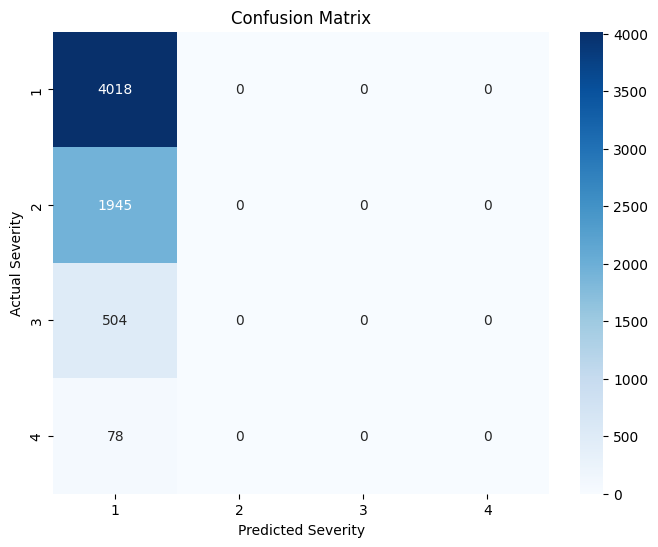

In [22]:
# Get the predicted class (severity level)
predicted = result.predict().argmax(axis=1) + 1  # +1 because argmax is zero-indexed
actual = df["COLLISION_SEVERITY"]

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

# Visualize it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1, 2, 3, 4],
            yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix')
plt.show()

# Analysis for Santa Clara

In [7]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel

def remap_severity(severity_series):
    """
    Remap collision severity values to a reversed scale and convert to an ordered categorical variable.
    
    The function converts severity scores from the original scale to a reversed scale as follows:
        1 → 4
        2 → 3
        3 → 2
        4 → 1
        
    Parameters:
    severity_series (pd.Series): Series containing collision severity values as strings or numbers.
    
    Returns:
    pd.Categorical: An ordered categorical series with severity levels [1, 2, 3, 4],
                    where 1 represents the least severe and 4 the most severe.
    """
    # Convert severity values to numeric, coercing errors to NaN
    severity_numeric = pd.to_numeric(severity_series, errors="coerce")
    # Define the mapping from original to reversed scale
    severity_mapping = {1: 4, 2: 3, 3: 2, 4: 1}
    remapped = severity_numeric.map(severity_mapping)
    # Define the order for the categorical variable
    severity_order = [1, 2, 3, 4]
    return pd.Categorical(remapped, categories=severity_order, ordered=True)

def categorize_time_of_day(time_str):
    """
    Categorize a time (given as a string) into a time-of-day group.
    
    The function interprets the input as a time in HHMM format and assigns:
        "M" for Morning (06:00 - 11:59),
        "A" for Afternoon (12:00 - 17:59),
        "E" for Evening (18:00 - 23:59),
        "N" for Night (00:00 - 05:59).
    
    Parameters:
    time_str (str): A string representing the time in HHMM format (e.g., "0600" for 6:00 AM).
    
    Returns:
    str: A single character representing the time of day ("M", "A", "E", or "N").
         If the input is invalid, returns np.nan.
    """
    try:
        time_int = int(time_str)
        if 600 <= time_int < 1200:
            return "M"  # Morning
        elif 1200 <= time_int < 1800:
            return "A"  # Afternoon
        elif 1800 <= time_int < 2400:
            return "E"  # Evening
        elif 0 <= time_int < 600:
            return "N"  # Night
    except (ValueError, TypeError):
        return np.nan

# Load dataset
file_path = "Crashes.csv"  # Update with the actual file path
df = pd.read_csv("Crashes_SantaClara_2223.csv", dtype=str)

# Keep only relevant columns
columns_to_keep = ["COLLISION_SEVERITY", "DAY_OF_WEEK", "COLLISION_TIME"]
df = df[columns_to_keep]

# Apply severity remapping using the dedicated function
df["COLLISION_SEVERITY"] = remap_severity(df["COLLISION_SEVERITY"])

# Create TIME_OF_DAY by categorizing COLLISION_TIME and convert to a categorical variable
df["TIME_OF_DAY"] = df["COLLISION_TIME"].apply(categorize_time_of_day).astype("category")
df.drop(columns=["COLLISION_TIME"], inplace=True)

# Collapse DAY_OF_WEEK into "Weekday" (Mon-Fri) vs. "Weekend" (Sat-Sun)
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].apply(lambda x: "Weekday" if x in ["1", "2", "3", "4", "5"] else "Weekend")




In [8]:
# Apply dummy encoding, keeping "Weekday" as the reference category
df = pd.get_dummies(df, columns=["DAY_OF_WEEK", "TIME_OF_DAY"], drop_first=True)

# Define independent variables (all columns except the target)
independent_vars = df.columns.difference(["COLLISION_SEVERITY"])

# Specify and calibrate the Ordered Logit Model
model = OrderedModel(
    df["COLLISION_SEVERITY"],
    df[independent_vars],
    distr="logit"
)

result = model.fit(method="bfgs")
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.937131
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:     COLLISION_SEVERITY   Log-Likelihood:                -12038.
Model:                   OrderedModel   AIC:                         2.409e+04
Method:            Maximum Likelihood   BIC:                         2.414e+04
Date:                Sun, 09 Mar 2025                                         
Time:                        20:21:00                                         
No. Observations:               12846                                         
Df Residuals:                   12839                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [9]:
# Compute and display Odds Ratios
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:\n", odds_ratios)

# Predict probabilities for each severity level
predicted_probs = result.predict()

# Convert predictions to a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs)

# Determine the most likely severity level for each observation
df["Predicted_Severity"] = predicted_probs_df.idxmax(axis=1)

# Display performance metrics with a confusion matrix (objective results only)
confusion_matrix = pd.crosstab(df["COLLISION_SEVERITY"], df["Predicted_Severity"],
                               rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", confusion_matrix)



Odds Ratios:
 DAY_OF_WEEK_Weekend    1.288056
TIME_OF_DAY_E          1.354834
TIME_OF_DAY_M          0.963877
TIME_OF_DAY_N          2.170786
1/2                    1.558733
2/3                    2.153203
3/4                    1.681262
dtype: float64

Confusion Matrix:
 Predicted     0    1
Actual              
1          6662  519
2          4026  528
3           726  160
4           162   63


[[6662  519    0    0]
 [4026  528    0    0]
 [ 726  160    0    0]
 [ 162   63    0    0]]


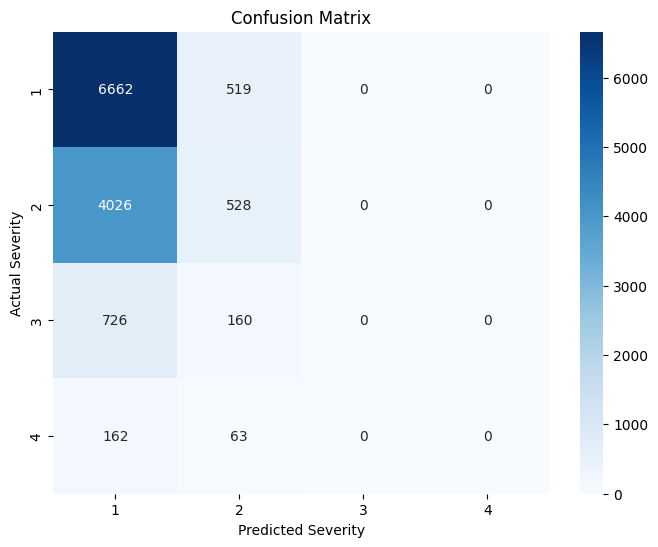

In [10]:
# Get the predicted class (severity level)
predicted = result.predict().argmax(axis=1) + 1  # +1 because argmax is zero-indexed
actual = df["COLLISION_SEVERITY"]

# Create confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

# Visualize it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1, 2, 3, 4],
            yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix')
plt.show()